# Import

In [1]:
import pandas as pd
import os
import numpy as np
from datetime import datetime, timedelta
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
import pandas_gbq

# Import Data

In [2]:
project_id = "rental-price-prediction"
query_landed = """
SELECT * FROM ura_data.landed_data;
"""
query_nonlanded = """
SELECT * FROM ura_data.nonlanded_data;
"""
landed = pandas_gbq.read_gbq(query_landed, project_id=project_id, dialect="standard") # Terrace House, Detached House, Semi-Detached House
nonlanded = pandas_gbq.read_gbq(query_nonlanded, project_id=project_id, dialect="standard") # Non-landed Properties, Executive Condominium

Downloading: 100%|██████████|
Downloading: 100%|██████████|


In [3]:
landed

,leaseDate,propertyType,district,rent,street,x,y,project,refPeriod,areaSqft_formatted,leaseYear,leaseQuarter,leaseMonth
0,2022-06-01 00:00:00+00:00,Terrace House,19,6750.0,KOVAN CLOSE,0.000000,0.000000,LANDED HOUSING DEVELOPMENT,2022Q2,2250.0,2022,2,6
1,2022-06-01 00:00:00+00:00,Terrace House,15,5300.0,JOO CHIAT TERRACE,0.000000,0.000000,LANDED HOUSING DEVELOPMENT,2022Q2,1250.0,2022,2,6
2,2022-06-01 00:00:00+00:00,Terrace House,19,1550.0,KANG CHOO BIN ROAD,0.000000,0.000000,LANDED HOUSING DEVELOPMENT,2022Q2,1000.0,2022,2,6
3,2022-06-01 00:00:00+00:00,Terrace House,19,1550.0,KANG CHOO BIN ROAD,0.000000,0.000000,LANDED HOUSING DEVELOPMENT,2022Q2,1000.0,2022,2,6
4,2022-06-01 00:00:00+00:00,Terrace House,15,2700.0,JOO CHIAT TERRACE,0.000000,0.000000,LANDED HOUSING DEVELOPMENT,2022Q2,1250.0,2022,2,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20657,2021-10-01 00:00:00+00:00,Semi-Detached House,26,5200.0,COUNTRYSIDE ROAD,28827.691650,41078.383320,LANDED HOUSING DEVELOPMENT,2021Q4,3250.0,2021,4,10
20658,2021-10-01 00:00:00+00:00,Semi-Detached House,26,6400.0,COUNTRYSIDE ROAD,28827.691650,41078.383320,LANDED HOUSING DEVELOPMENT,2021Q4,2750.0,2021,4,10
20659,2021-10-01 00:00:00+00:00,Semi-Detached House,26,6400.0,COUNTRYSIDE ROAD,28827.691650,41078.383320,LANDED HOUSING DEVELOPMENT,2021Q4,2750.0,2021,4,10
20660,2021-10-01 00:00:00+00:00,Semi-Detached House,26,5200.0,COUNTRYSIDE ROAD,28827.691650,41078.383320,LANDED HOUSING DEVELOPMENT,2021Q4,3250.0,2021,4,10


In [4]:
nonlanded

,leaseDate,propertyType,district,noOfBedRoom,rent,street,x,y,project,refPeriod,areaSqft_formatted,leaseYear,leaseQuarter,leaseMonth,median
0,2021-03-01 00:00:00+00:00,Non-landed Properties,08,3,3700.0,SERANGOON ROAD,0.00000,0.00000,NON-LANDED HOUSING DEVELOPMENT,2021Q1,1550.0,2021,1,3,2.000000
1,2021-03-01 00:00:00+00:00,Non-landed Properties,09,4,5876.0,CAIRNHILL RISE,28672.97336,32089.39989,THE CAIRNHILL,2021Q1,2650.0,2021,1,3,2.360000
2,2021-01-01 00:00:00+00:00,Non-landed Properties,09,4,5876.0,CAIRNHILL RISE,28672.97336,32089.39989,THE CAIRNHILL,2021Q1,2550.0,2021,1,1,2.360000
3,2021-01-01 00:00:00+00:00,Non-landed Properties,09,4,5876.0,CAIRNHILL RISE,28672.97336,32089.39989,THE CAIRNHILL,2021Q1,2650.0,2021,1,1,2.360000
4,2021-02-01 00:00:00+00:00,Non-landed Properties,09,4,6330.0,CAIRNHILL RISE,28672.97336,32089.39989,THE CAIRNHILL,2021Q1,2550.0,2021,1,2,2.360000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237225,2023-12-01 00:00:00+00:00,Non-landed Properties,09,2,6400.0,ROBERTSON QUAY,28448.46801,30367.56831,UP@ROBERTSON QUAY,2023Q4,1150.0,2023,4,12,3.739130
237226,2023-11-01 00:00:00+00:00,Non-landed Properties,09,2,6300.0,ROBERTSON QUAY,28448.46801,30367.56831,UP@ROBERTSON QUAY,2023Q4,1150.0,2023,4,11,3.739130
237227,2023-11-01 00:00:00+00:00,Non-landed Properties,09,2,6300.0,ROBERTSON QUAY,28448.46801,30367.56831,UP@ROBERTSON QUAY,2023Q4,1150.0,2023,4,11,3.739130
237228,2023-10-01 00:00:00+00:00,Non-landed Properties,09,1,4300.0,ROBERTSON QUAY,28448.46801,30367.56831,UP@ROBERTSON QUAY,2023Q4,550.0,2023,4,10,7.818182


# One Hot Encoding

In [5]:
def encode_df(df):
    """ one hot encoding of features district and propertyType, first category dropped"""
    df['district'] = df['district'].astype('category')
    df['propertyType'] = df['propertyType'].astype('category')
    df = pd.get_dummies(df, columns=["district", "propertyType"], drop_first=True)
    return df

landed_encoded = encode_df(landed)
nonlanded_encoded = encode_df(nonlanded)
print(landed_encoded.shape)
print(nonlanded_encoded.shape)

(20662, 38)
(237230, 40)


# Run RF on All Features

## Landed

In [4]:
X_features = list(landed_encoded.columns)
for col in ['leaseDate', 'street', 'x', 'y', 'project', 'refPeriod', 'rent']:
    # remove these non-numerical / irrelavant features / target
    X_features.remove(col)
    
for col in ['leaseQuarter',]:
    # remove cols causing high colinearity
    X_features.remove(col)
print(X_features)

X_train, X_test, y_train, y_test = train_test_split(landed_encoded[X_features], landed_encoded["rent"], test_size=0.2, random_state=42)

parameters = {'n_estimators': np.arange(8, 15, 2),
              'max_depth' : [9],
              'max_features': ['log2'],
              'criterion' :['absolute_error', 'poisson', 'squared_error', 'friedman_mse'],
              'random_state': [42]}
cv = GridSearchCV(estimator = RandomForestRegressor(),  
                           param_grid = parameters,
                           scoring = 'neg_mean_absolute_error',
                           cv = 5,
                           verbose=0)
cv.fit(X_train, y_train)
print(cv.best_params_)

['areaSqft_formatted', 'leaseYear', 'leaseMonth', 'district_02', 'district_03', 'district_04', 'district_05', 'district_07', 'district_08', 'district_09', 'district_10', 'district_11', 'district_12', 'district_13', 'district_14', 'district_15', 'district_16', 'district_17', 'district_18', 'district_19', 'district_20', 'district_21', 'district_22', 'district_23', 'district_25', 'district_26', 'district_27', 'district_28', 'propertyType_Semi-Detached House', 'propertyType_Terrace House']
{'criterion': 'absolute_error', 'max_depth': 9, 'max_features': 'sqrt', 'n_estimators': 12, 'random_state': 42}


training r2: 0.5779521657780389
testing r2: 0.5496921375687611

score   = 0.5496921375687611
r2      = 0.5496921375687611
MAE     = 2602.9533026857002
RMSE    = 5563.424819214172
MSE     = 30951695.719048247
MAE %   = 0.2873748757846367



Text(0.5, 1.0, 'Predicted against Actual (Testing Set)')

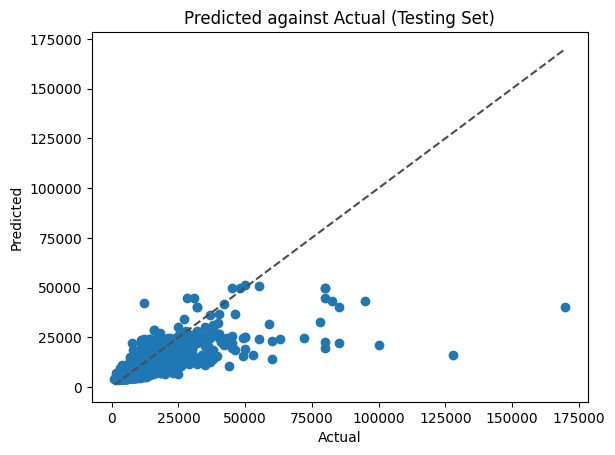

In [5]:
model = RandomForestRegressor(n_estimators=cv.best_params_["n_estimators"], 
                              max_depth=cv.best_params_["max_depth"],
                              max_features=cv.best_params_["max_features"],
                              criterion=cv.best_params_["criterion"],
                              random_state=42)
model.fit(X_train, y_train)
print(f"training r2: {model.score(X_train, y_train)}")
print(f"testing r2: {model.score(X_test, y_test)}")
pred = model.predict(X_test)
results = pd.DataFrame({"true_values": y_test, "predictions": pred})
results["error"] = results["true_values"] - results["predictions"]
print(f"""
score   = {model.score(X_test, y_test)}
r2      = {r2_score(y_test, pred)}
MAE     = {mean_absolute_error(y_test, pred)}
RMSE    = {mean_squared_error(y_test, pred, squared=False)}
MSE     = {mean_squared_error(y_test, pred)}
MAE %   = {mean_absolute_percentage_error(y_test, pred)}
""")

plt.scatter(y_test, pred)
diag_line_lower, diag_line_upper = min(min(y_test), min(pred)), max(max(y_test), max(pred))
plt.plot([diag_line_lower, diag_line_upper], [diag_line_lower, diag_line_upper], ls="--", c=".3")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted against Actual (Testing Set)")

### Feature Importance Plot

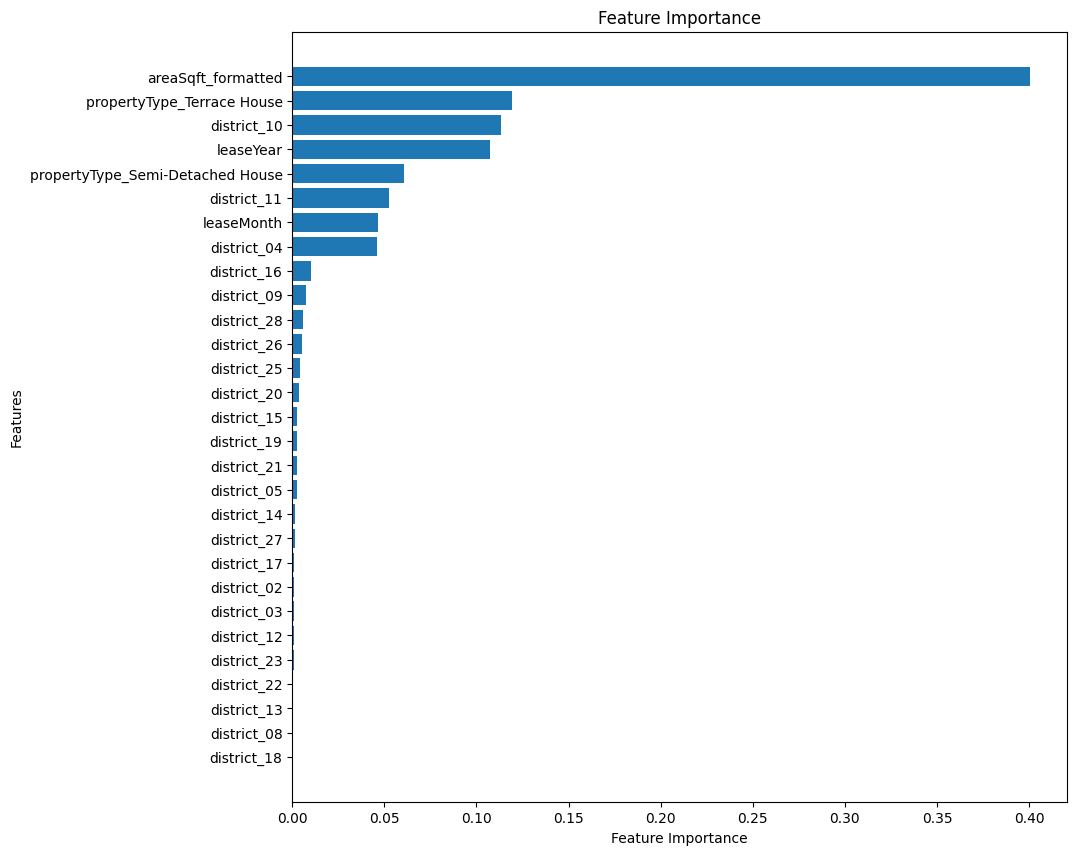

In [9]:
feature_importances = pd.DataFrame({"Feature": X_train.columns, "Importance": model.feature_importances_}).sort_values("Importance")
nonzero_feature_importances = feature_importances[feature_importances["Importance"] != 0]

plt.figure(figsize=(10,10))
plt.barh(nonzero_feature_importances["Feature"], nonzero_feature_importances["Importance"])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

### Run RF on Selected Features

In [10]:
nonzero_feature_importances.sort_values("Importance", ascending=False)["Feature"]

0                   areaSqft_formatted
29          propertyType_Terrace House
10                         district_10
1                            leaseYear
28    propertyType_Semi-Detached House
11                         district_11
2                           leaseMonth
5                          district_04
16                         district_16
9                          district_09
27                         district_28
25                         district_26
24                         district_25
20                         district_20
15                         district_15
19                         district_19
21                         district_21
6                          district_05
14                         district_14
26                         district_27
17                         district_17
3                          district_02
4                          district_03
12                         district_12
23                         district_23
22                       

Fitting 5 folds for each of 224 candidates, totalling 1120 fits
{'criterion': 'absolute_error', 'max_depth': 9, 'max_features': 'log2', 'n_estimators': 14, 'random_state': 42}
training r2: 0.6178321529959317
testing r2: 0.563665628806814

score   = 0.563665628806814
r2      = 0.563665628806814
MAE     = 2549.5286630258197
RMSE    = 5476.425337464789
MSE     = 29991234.47682633
MAE %   = 0.27182052913476307



Text(0.5, 1.0, 'Predicted against Actual (Testing Set)')

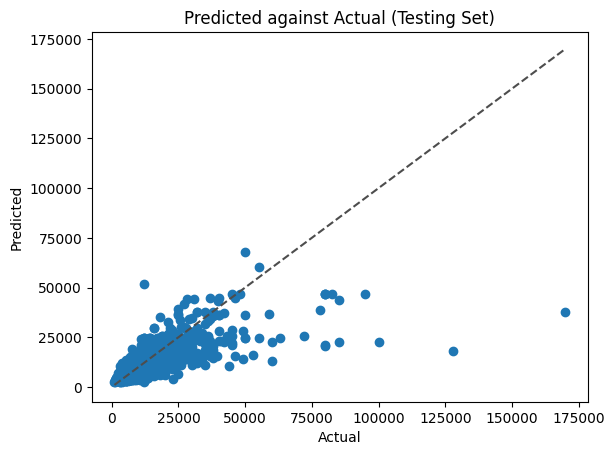

In [11]:
selected_features = [
              "areaSqft_formatted",
      "propertyType_Terrace House",
                     "district_10",
                       "leaseYear",
"propertyType_Semi-Detached House",
                     "district_11",
                      "leaseMonth",
                     "district_04",
]
select_X_train = X_train[selected_features]
select_X_test = X_test[selected_features]


# Define the hyperparameters grid for grid search
param_grid = {'n_estimators': np.arange(8, 15, 2),
            'max_depth' : [3,5,7,9],
            'max_features': ['log2'],
            'criterion' :['absolute_error'],
            'random_state': [42]}

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',  # Evaluate multiple metrics
    cv=5,                              # Number of cross-validation folds
    verbose=1,
    n_jobs=-1
)

# Fit the grid search to the training data
grid_search.fit(select_X_train, y_train)

# Get the best model and its hyperparameters
selection_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print(best_params)
model = RandomForestRegressor(n_estimators=best_params["n_estimators"], 
                              max_depth=best_params["max_depth"],
                              max_features=best_params["max_features"],
                              criterion=best_params["criterion"],
                              random_state=42)
model.fit(select_X_train, y_train)
print(f"training r2: {model.score(select_X_train, y_train)}")
print(f"testing r2: {model.score(select_X_test, y_test)}")
pred = model.predict(select_X_test)
results = pd.DataFrame({"true_values": y_test, "predictions": pred})
results["error"] = results["true_values"] - results["predictions"]
print(f"""
score   = {model.score(select_X_test, y_test)}
r2      = {r2_score(y_test, pred)}
MAE     = {mean_absolute_error(y_test, pred)}
RMSE    = {mean_squared_error(y_test, pred, squared=False)}
MSE     = {mean_squared_error(y_test, pred)}
MAE %   = {mean_absolute_percentage_error(y_test, pred)}
""")

plt.scatter(y_test, pred)
diag_line_lower, diag_line_upper = min(min(y_test), min(pred)), max(max(y_test), max(pred))
plt.plot([diag_line_lower, diag_line_upper], [diag_line_lower, diag_line_upper], ls="--", c=".3")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted against Actual (Testing Set)")


In [ ]:
nonzero_feature_importances.sort_values("Importance", ascending=False)["Feature"]

0                   areaSqft_formatted
29          propertyType_Terrace House
10                         district_10
1                            leaseYear
28    propertyType_Semi-Detached House
11                         district_11
2                           leaseMonth
5                          district_04
16                         district_16
9                          district_09
27                         district_28
25                         district_26
24                         district_25
20                         district_20
15                         district_15
19                         district_19
21                         district_21
6                          district_05
14                         district_14
26                         district_27
17                         district_17
3                          district_02
4                          district_03
12                         district_12
23                         district_23
22                       

## Non-Landed

In [6]:
X_features = list(nonlanded_encoded.columns)
for col in ['leaseDate', 'street', 'x', 'y', 'project', 'refPeriod', 'rent',]:
    # remove these non-numerical / irrelavant features / target
    X_features.remove(col)
print(X_features)
for col in ['leaseQuarter', 'noOfBedRoom']:
    # remove cols causing high colinearity
    X_features.remove(col)

X_train, X_test, y_train, y_test = train_test_split(nonlanded_encoded[X_features], nonlanded_encoded["rent"], test_size=0.2, random_state=42)

parameters = {'n_estimators': np.arange(8, 15, 2),
              'max_depth' : [9],
              'max_features': ['log2'],
              'criterion' :['absolute_error'],
              'random_state': [42]}
cv = GridSearchCV(estimator = RandomForestRegressor(),  
                           param_grid = parameters,
                           scoring = 'neg_mean_absolute_error',
                           cv = 5,
                           verbose=0)
cv.fit(X_train, y_train)
print(cv.best_params_)

['noOfBedRoom', 'areaSqft_formatted', 'leaseYear', 'leaseQuarter', 'leaseMonth', 'median', 'district_02', 'district_03', 'district_04', 'district_05', 'district_06', 'district_07', 'district_08', 'district_09', 'district_10', 'district_11', 'district_12', 'district_13', 'district_14', 'district_15', 'district_16', 'district_17', 'district_18', 'district_19', 'district_20', 'district_21', 'district_22', 'district_23', 'district_25', 'district_26', 'district_27', 'district_28', 'propertyType_Non-landed Properties']


training r2: 0.5784380948307762
testing r2: 0.5015586727351088

score   = 0.5015586727351088
r2      = 0.5015586727351088
MAE     = 2775.084876169732
RMSE    = 6339.37116772002
MSE     = 40187626.80211989
MAE %   = 0.2943515013037133



Text(0.5, 1.0, 'Predicted against Actual (Testing Set)')

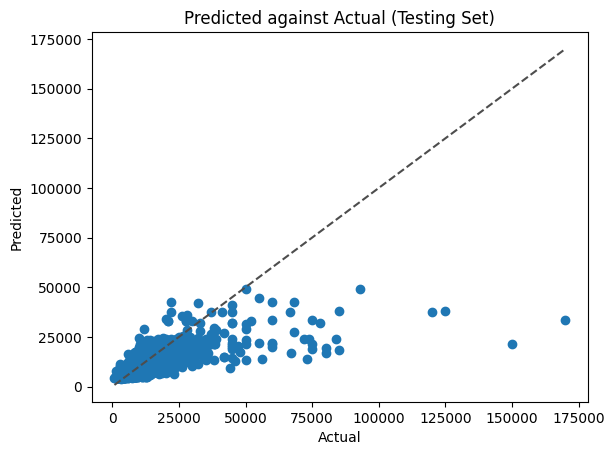

In [ ]:
model = RandomForestRegressor(n_estimators=cv.best_params_["n_estimators"], 
                              max_depth=cv.best_params_["max_depth"],
                              max_features=cv.best_params_["max_features"],
                              criterion=cv.best_params_["criterion"],
                              random_state=42)
model.fit(X_train, y_train)
print(f"training r2: {model.score(X_train, y_train)}")
print(f"testing r2: {model.score(X_test, y_test)}")
pred = model.predict(X_test)
results = pd.DataFrame({"true_values": y_test, "predictions": pred})
results["error"] = results["true_values"] - results["predictions"]
print(f"""
score   = {model.score(X_test, y_test)}
r2      = {r2_score(y_test, pred)}
MAE     = {mean_absolute_error(y_test, pred)}
RMSE    = {mean_squared_error(y_test, pred, squared=False)}
MSE     = {mean_squared_error(y_test, pred)}
MAE %   = {mean_absolute_percentage_error(y_test, pred)}
""")

plt.scatter(y_test, pred)
diag_line_lower, diag_line_upper = min(min(y_test), min(pred)), max(max(y_test), max(pred))
plt.plot([diag_line_lower, diag_line_upper], [diag_line_lower, diag_line_upper], ls="--", c=".3")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted against Actual (Testing Set)")

### Feature Importance Plot

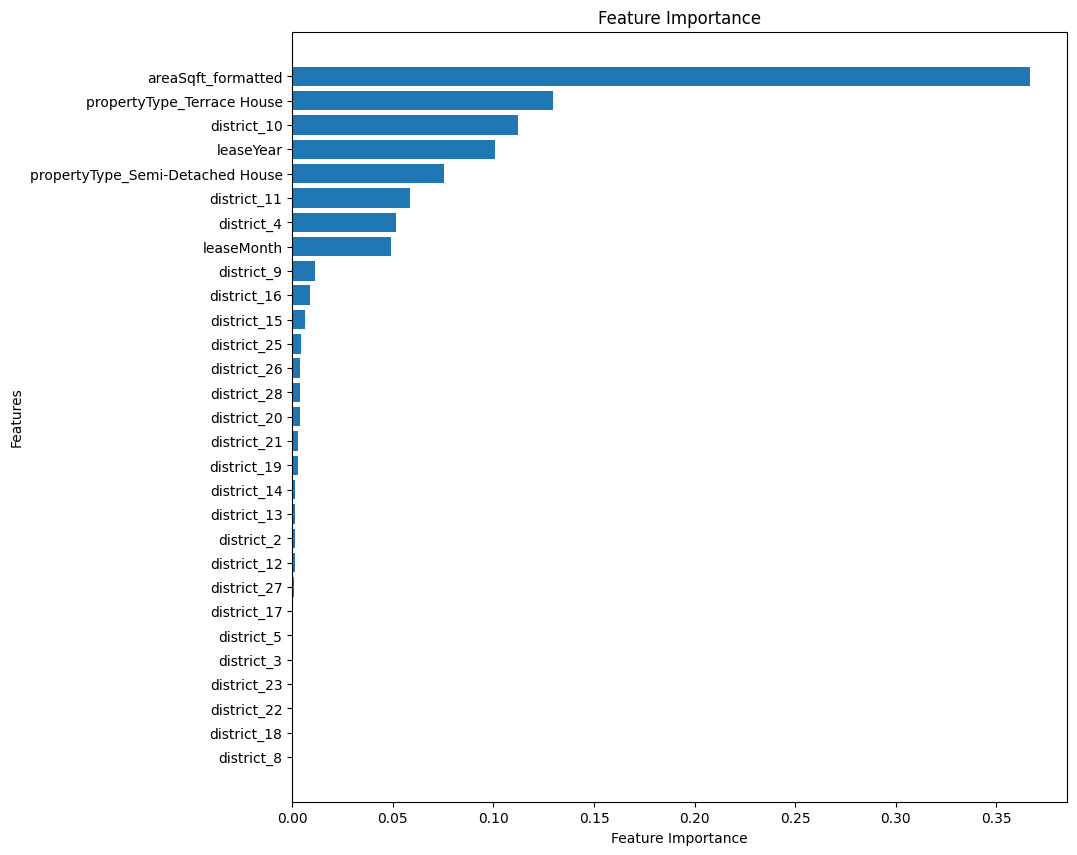

In [ ]:
feature_importances = pd.DataFrame({"Feature": X_train.columns, "Importance": model.feature_importances_}).sort_values("Importance")
nonzero_feature_importances = feature_importances[feature_importances["Importance"] != 0]

plt.figure(figsize=(10,10))
plt.barh(nonzero_feature_importances["Feature"], nonzero_feature_importances["Importance"])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

### Run RF on Selected Features

In [ ]:
nonzero_feature_importances.sort_values("Importance", ascending=False)["Feature"]

0                   areaSqft_formatted
29          propertyType_Terrace House
10                         district_10
1                            leaseYear
28    propertyType_Semi-Detached House
11                         district_11
5                           district_4
2                           leaseMonth
9                           district_9
16                         district_16
15                         district_15
24                         district_25
25                         district_26
27                         district_28
20                         district_20
21                         district_21
19                         district_19
14                         district_14
13                         district_13
3                           district_2
12                         district_12
26                         district_27
17                         district_17
6                           district_5
4                           district_3
23                       

Fitting 5 folds for each of 224 candidates, totalling 1120 fits


{'criterion': 'absolute_error', 'max_depth': 9, 'max_features': 'log2', 'n_estimators': 14, 'random_state': 42}
training r2: 0.6314536323813653
testing r2: 0.5187826569256224

score   = 0.5187826569256224
r2      = 0.5187826569256224
MAE     = 2727.747450214355
RMSE    = 6228.877556365559
MSE     = 38798915.61219458
MAE %   = 0.2799436264376655



Text(0.5, 1.0, 'Predicted against Actual (Testing Set)')

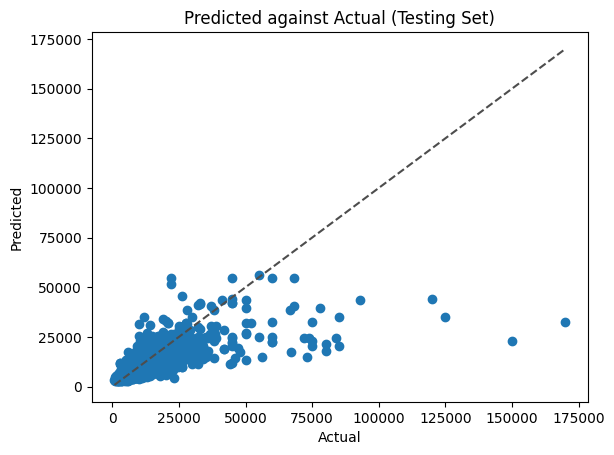

In [ ]:
selected_features = [
              "areaSqft_formatted",
      "propertyType_Terrace House",
                     "district_10",
                       "leaseYear",
"propertyType_Semi-Detached House",
                     "district_11",
                      "district_4",
                      "leaseMonth",
]
select_X_train = X_train[selected_features]
select_X_test = X_test[selected_features]


# Define the hyperparameters grid for grid search
param_grid = {'n_estimators': np.arange(8, 15, 2),
            'max_depth' : [9],
            'max_features': ['log2'],
            'criterion' :['absolute_error'],
            'random_state': [42]}

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',  # Evaluate multiple metrics
    cv=5,                              # Number of cross-validation folds
    verbose=1,
    n_jobs=-1
)

# Fit the grid search to the training data
grid_search.fit(select_X_train, y_train)

# Get the best model and its hyperparameters
selection_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print(best_params)
model = RandomForestRegressor(n_estimators=best_params["n_estimators"], 
                              max_depth=best_params["max_depth"],
                              max_features=best_params["max_features"],
                              criterion=best_params["criterion"],
                              random_state=42)
model.fit(select_X_train, y_train)
print(f"training r2: {model.score(select_X_train, y_train)}")
print(f"testing r2: {model.score(select_X_test, y_test)}")
pred = model.predict(select_X_test)
results = pd.DataFrame({"true_values": y_test, "predictions": pred})
results["error"] = results["true_values"] - results["predictions"]
print(f"""
score   = {model.score(select_X_test, y_test)}
r2      = {r2_score(y_test, pred)}
MAE     = {mean_absolute_error(y_test, pred)}
RMSE    = {mean_squared_error(y_test, pred, squared=False)}
MSE     = {mean_squared_error(y_test, pred)}
MAE %   = {mean_absolute_percentage_error(y_test, pred)}
""")

plt.scatter(y_test, pred)
diag_line_lower, diag_line_upper = min(min(y_test), min(pred)), max(max(y_test), max(pred))
plt.plot([diag_line_lower, diag_line_upper], [diag_line_lower, diag_line_upper], ls="--", c=".3")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted against Actual (Testing Set)")


$ ln Y = \beta_0 + \beta_1 X_1 + … + \beta_p X_p$
